In [390]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 200)

In [391]:
raw_df = pd.read_csv('ha_data.csv', delimiter=';')

In [392]:
raw_df

,order_id,page_id,product,site_version,time,title,user
0,NaN,3.0,company,mobile,2017-02-09 20:24:04,banner_show,user_0
1,NaN,3699687.0,company,mobile,2017-02-07 10:03:07,banner_show,user_0
2,NaN,14.0,sneakers,mobile,2017-01-29 13:02:23,banner_show,user_1
3,NaN,10362176.0,company,mobile,2017-04-12 15:39:19,banner_show,user_1
4,NaN,14.0,sneakers,mobile,2017-01-29 13:04:42,banner_click,user_1
...,...,...,...,...,...,...,...
8471221,NaN,24897184.0,accessories,desktop,2017-05-23 14:07:00,banner_show,user_4254616
8471222,NaN,24897190.0,clothes,mobile,2017-05-28 08:10:20,banner_show,user_4254617
8471223,NaN,24897203.0,sports_nutrition,mobile,2017-05-20 09:20:50,banner_show,user_4254618
8471224,NaN,24897205.0,sneakers,mobile,2017-05-28 19:25:42,banner_show,user_4254619


In [393]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8471226 entries, 0 to 8471225
Data columns (total 7 columns):
 #   Column        Dtype  
---  ------        -----  
 0   order_id      float64
 1   page_id       float64
 2   product       object 
 3   site_version  object 
 4   time          object 
 5   title         object 
 6   user          object 
dtypes: float64(2), object(5)
memory usage: 452.4+ MB


In [394]:
raw_df.isnull().sum()

order_id        8222504
page_id          248722
product               0
site_version          0
time                  0
title                 0
user                  0
dtype: int64

Видно, что там, где наллов не должно быть, их нет. Но типы данных в таблицы не оптимальные. Если в дальнейшем потребуется использовать эти даннные (например, для обучения моделей), то можно типы оптимизировать. Фор экзампл, категориальные столбцы (остальное оставим, тк задача не в этом)

In [395]:
raw_df[['product', 'site_version', 'title']] = raw_df[['product', 'site_version', 'title']].astype('category')

Сразу же почти в два раза выиграли по памяти:

In [396]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8471226 entries, 0 to 8471225
Data columns (total 7 columns):
 #   Column        Dtype   
---  ------        -----   
 0   order_id      float64 
 1   page_id       float64 
 2   product       category
 3   site_version  category
 4   time          object  
 5   title         category
 6   user          object  
dtypes: category(3), float64(2), object(2)
memory usage: 282.8+ MB


In [397]:
raw_df['time'] = pd.to_datetime(raw_df['time'])

In [398]:
print(f'Датасет собирался с {raw_df['time'].min()} по {raw_df['time'].max()}')

Датасет собирался с 2017-01-01 00:00:03 по 2017-05-31 23:59:58


Посмотрим на категории:

In [399]:
print(f'Баннер: {', '.join(list(raw_df['product'].unique()))}')
print(f'Версия: {', '.join(list(raw_df['site_version'].unique()))}')
print(f'Действие: {', '.join(list(raw_df['title'].unique()[:]))}')

Баннер: company, sneakers, sports_nutrition, accessories, clothes
Версия: mobile, desktop
Действие: banner_show, banner_click, order


Давайте первым делом посмотрим на распределение категориальных признаков.
1. Количество показов и уникальных показов баннеров

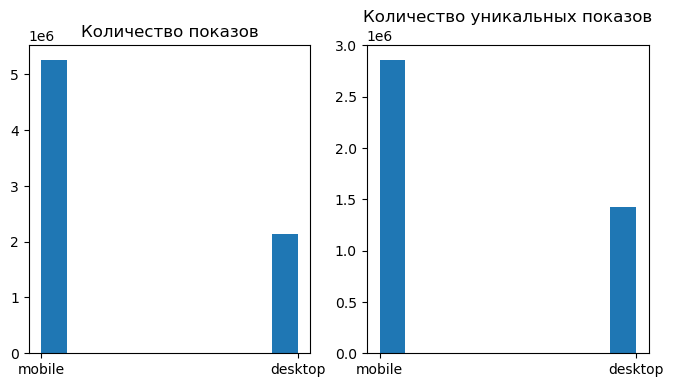

In [400]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

axs[0].hist(x='site_version', data=pd.DataFrame(raw_df.loc[raw_df['title'] == 'banner_show', 'site_version']))
axs[0].set_title("Количество показов")
axs[1].hist(x='site_version', data=raw_df.loc[raw_df['title'] == 'banner_show', ['site_version', 'user']].drop_duplicates())
axs[1].set_title("Количество уникальных показов")
plt.show()

Результат понятен: телефон всегда под рукой, пользоваться легко и удобно.
В дальнейшем рассмотрим десктопную и мобильную версии отдельно

In [401]:
desktop_df = raw_df.loc[raw_df['site_version'] == 'desktop']
mobile_df = raw_df.loc[raw_df['site_version'] == 'mobile']

"Среднее количество показов" на клиента в каждой версии:

In [402]:
print(f'Десктопная:{round(len(desktop_df['user'].unique())/desktop_df.loc[(raw_df['title'] == 'banner_show'), 'user'].shape[0], 2)}')
print(f'Мобильная:{round(len(mobile_df['user'].unique())/mobile_df.loc[(raw_df['title'] == 'banner_show'), 'user'].shape[0], 2)}')

Десктопная:0.67
Мобильная:0.54


Фиксируем, что в среднем на десктопной версии чаще 'наталкиваются на баннеры' (предположительно, из-за особенностей навигации). Далее переходим к детальному анализу каждой из категорий

Проверим количество показов в каждой из категорий

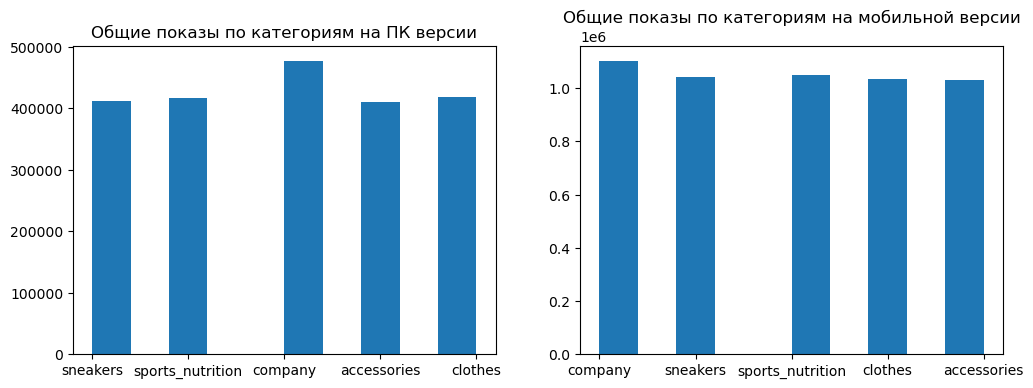

In [403]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axs[0].hist(x='product', data=pd.DataFrame(desktop_df.loc[raw_df['title'] == 'banner_show', 'product']))
axs[0].set_title("Общие показы по категориям на ПК версии")
axs[1].hist(x='product', data=pd.DataFrame(mobile_df.loc[raw_df['title'] == 'banner_show', 'product']))
axs[1].set_title("Общие показы по категориям на мобильной версии")
plt.show()

Видим, что количества показов по категориям почти равные, реклама компании в целом немного активнее (это вопрос к тому, равны ли в действительности вероятности появления:) ).

Теперь исследуем нашу короткую пользовательскую воронку. Посмотрим на количество кликов по категориям

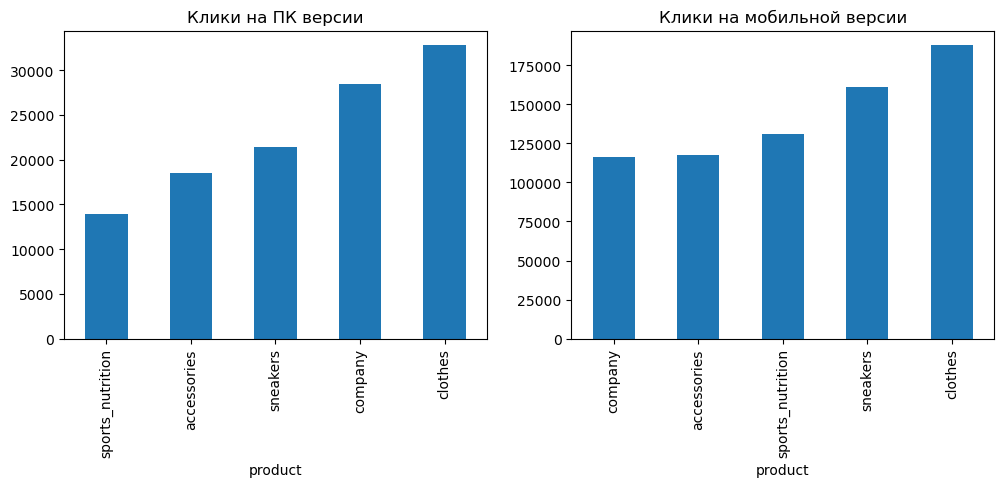

In [404]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

desktop_df.loc[raw_df['title'] == 'banner_click', 'product'].value_counts().sort_values().plot(kind='bar', ax=axs[0])
axs[0].set_title("Клики на ПК версии")
mobile_df.loc[raw_df['title'] == 'banner_click', 'product'].value_counts().sort_values().plot(kind='bar', ax=axs[1])
axs[1].set_title("Клики на мобильной версии")
plt.show()

Одежда в обоих версиях лидирует. Далее, пока непонятным образом, на вторым на ПК версии оказывается баннер компании, в то время как на мобильной он занимает последнее место. Это может говорить о качественно разной аудитории. Сравнивать количественно между собой левую и правую гистограммы не совсем правильно, так как для них количество пользователей разное. Лучше сравним конверсии: отношение количества кликнувших на баннер к количеству тех, кому его показали (aka кликабельность).

In [405]:
desktop_num_show = desktop_df.loc[desktop_df['title'] == 'banner_show', 'product'].value_counts()
desktop_num_click = desktop_df.loc[desktop_df['title'] == 'banner_click', 'product'].value_counts()
desktop_show_click_conversion = {product: clicks/desktop_num_show[product] for product, clicks in desktop_num_click.items()}

mobile_num_show = mobile_df.loc[mobile_df['title'] == 'banner_show', 'product'].value_counts()
mobile_num_click = mobile_df.loc[mobile_df['title'] == 'banner_click', 'product'].value_counts()
mobile_show_click_conversion = {product: clicks/mobile_num_show[product] for product, clicks in mobile_num_click.items()}

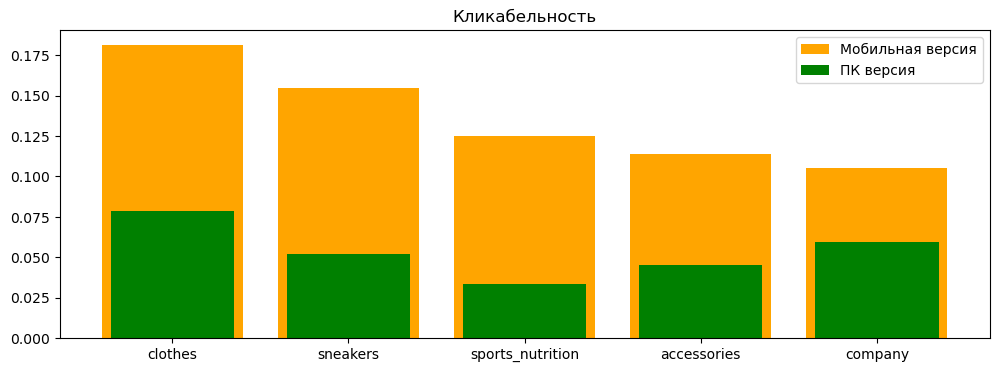

In [406]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.bar(mobile_show_click_conversion.keys(), mobile_show_click_conversion.values(), color='orange', alpha=1, label="Мобильная версия")
ax.bar(desktop_show_click_conversion.keys(), desktop_show_click_conversion.values(), color='green', alpha=1, width=0.7, label="ПК версия")

ax.legend()
ax.set_title('Кликабельность')
plt.show()

Видим, что конверсия по кликам в десктопе самая низкая для спортивного питания, а в мобильной версии для баннера компании. В целом конверсии на ПК версии значительно выше.

Теперь посмотрим на количество продаж (пока что нам неочевидно, что в датасете только те покупки, что были совершены после клика баннера, это мы исследуем позже)

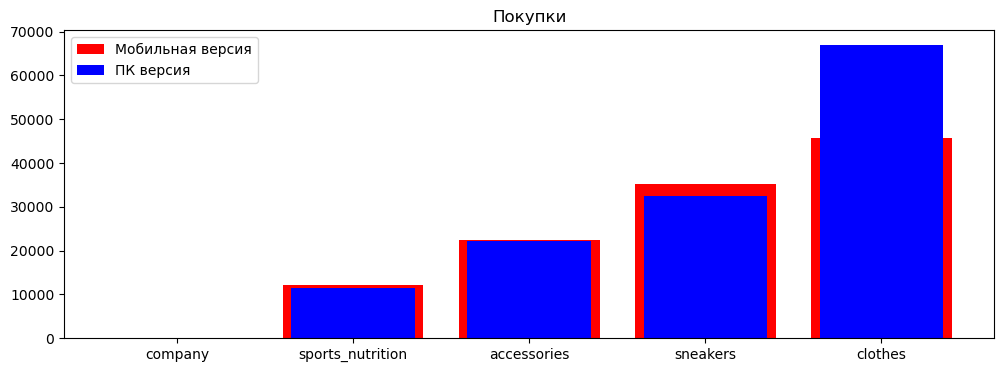

In [407]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.bar(mobile_df.loc[raw_df['title'] == 'order', 'product'].value_counts().sort_values().index, mobile_df.loc[raw_df['title'] == 'order', 'product'].value_counts().sort_values(), color='red', alpha=1, label="Мобильная версия")
ax.bar(desktop_df.loc[raw_df['title'] == 'order', 'product'].value_counts().sort_values().index, desktop_df.loc[raw_df['title'] == 'order', 'product'].value_counts().sort_values(), color='blue', alpha=1, width=0.7, label="ПК версия")

ax.legend()
ax.set_title('Покупки')
plt.show()

Видим, что продажи значительно отличаются для категории одежды. Посмотрим, какую часть в датасете имеют покупки, совершенные после клика по баннеру. Отберем только тех пользователей, кто в принципе совершил покупку.

In [408]:
desktop_order = desktop_df.loc[desktop_df['title'] == 'order']
mobile_order = mobile_df.loc[mobile_df['title'] == 'order']
desktop_order = desktop_df[desktop_df['user'].isin(desktop_order['user'])]
desktop_order['SortOrder'] = desktop_order.groupby('user')['time'].transform(lambda x: x.rank())
desktop_order = desktop_order.sort_values(['user', 'SortOrder']).drop(columns='SortOrder').reset_index(drop=True)
mobile_order = mobile_df[mobile_df['user'].isin(mobile_order['user'])]
mobile_order['SortOrder'] = mobile_order.groupby('user')['time'].transform(lambda x: x.rank())
mobile_order = mobile_order.sort_values(['user', 'SortOrder']).drop(columns='SortOrder').reset_index(drop=True)

C:\Users\ashuleshko\AppData\Local\Temp\ipykernel_12884\3109867851.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desktop_order['SortOrder'] = desktop_order.groupby('user')['time'].transform(lambda x: x.rank())
C:\Users\ashuleshko\AppData\Local\Temp\ipykernel_12884\3109867851.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mobile_order['SortOrder'] = mobile_order.groupby('user')['time'].transform(lambda x: x.rank())


In [409]:
desktop_order

,order_id,page_id,product,site_version,time,title,user
0,NaN,5249637.0,sneakers,desktop,2017-01-25 07:26:02,banner_show,user_1000031
1,NaN,5249745.0,company,desktop,2017-01-31 17:33:17,banner_show,user_1000031
2,328778.0,NaN,clothes,desktop,2017-02-02 03:25:03,order,user_1000031
3,557233.0,NaN,clothes,desktop,2017-01-15 02:09:14,order,user_1000084
4,NaN,5249941.0,accessories,desktop,2017-01-29 18:08:37,banner_show,user_1000084
...,...,...,...,...,...,...,...
451503,NaN,14473429.0,accessories,desktop,2017-04-10 19:11:26,banner_show,user_999951
451504,NaN,18577377.0,sneakers,desktop,2017-04-13 05:18:52,banner_show,user_999951
451505,NaN,18562841.0,company,desktop,2017-04-18 17:29:43,banner_show,user_999951
451506,NaN,17448090.0,accessories,desktop,2017-04-23 18:37:30,banner_show,user_999951


Для начала посмотрим, сколько пользователей совершило покупку в той категории, по которой кликнули (давайте будем считать, что для нас неважно, совершил пользователь покупку сразу после клика или в другой день - главное, что он был мотивирован)

In [410]:
desktop_click_order = desktop_order.loc[desktop_order['title'] == 'order', ['product', 'user']].merge(desktop_order.loc[(desktop_order['title'] == 'banner_click'), ['product', 'user']], how='inner')
mobile_click_order = mobile_order.loc[mobile_order['title'] == 'order', ['product', 'user']].merge(mobile_order.loc[(mobile_order['title'] == 'banner_click'), ['product', 'user']], how='inner')

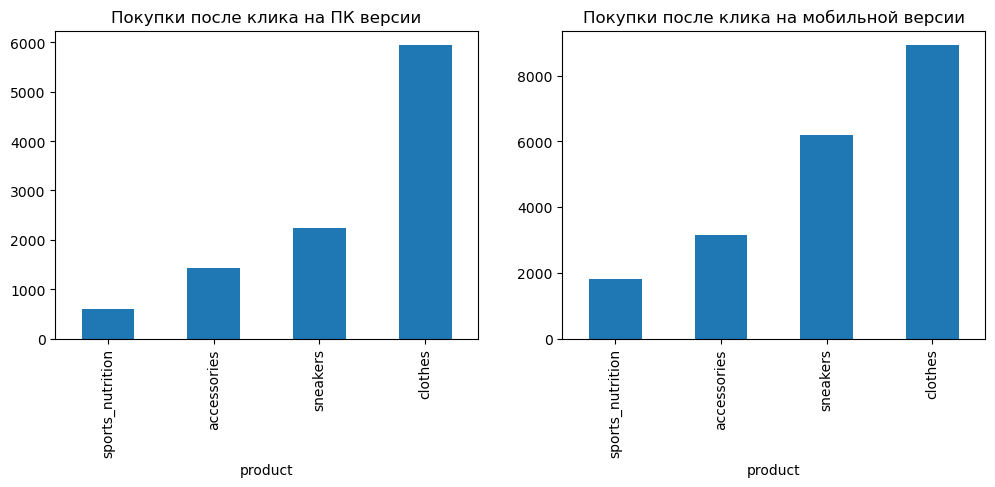

In [411]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

desktop_click_order['product'].value_counts().drop('company').sort_values().plot(kind='bar', ax=axs[0])
axs[0].set_title("Покупки после клика на ПК версии")
mobile_click_order['product'].value_counts().drop('company').sort_values().plot(kind='bar', ax=axs[1])
axs[1].set_title("Покупки после клика на мобильной версии")
plt.show()

Качественно поведение совпадает. Сравним конверсии (от клика по баннеру к покупке в этой категории)

In [412]:
desktop_num_click = desktop_df.loc[desktop_df['title'] == 'banner_click', 'product'].value_counts()
desktop_num_click_order = desktop_click_order['product'].value_counts().drop('company')
desktop_click_order_conversion = {product: orders/desktop_num_click[product] for product, orders in desktop_num_click_order.items()}

mobile_num_click = mobile_df.loc[mobile_df['title'] == 'banner_click', 'product'].value_counts()
mobile_num_click_order = mobile_click_order['product'].value_counts().drop('company')
mobile_click_order_conversion = {product: orders/mobile_num_click[product] for product, orders in mobile_num_click_order.items()}

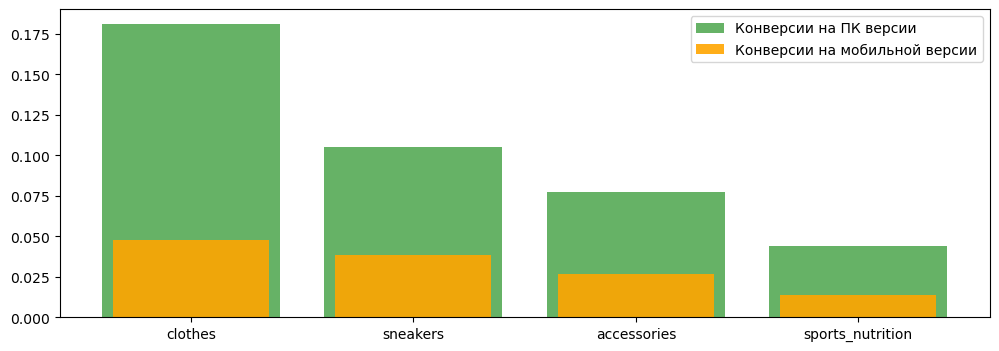

In [413]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.bar(desktop_click_order_conversion.keys(), desktop_click_order_conversion.values(), color='green', alpha=0.6, label="Конверсии на ПК версии")
ax.bar(mobile_click_order_conversion.keys(), mobile_click_order_conversion.values(), color='orange', alpha=0.9, width=0.7, label="Конверсии на мобильной версии")

ax.legend()
plt.show()

Как интересно всё обернулось... Видим, что конверсии с клика в покупку в той же категории на компьютерах значително выше, чем на телефонах. Получается, что на телефонах активно кликают, а на компьютерах активно покупают после клика) ну и для полноты можно сравнить конверсии с показа баннера в покупку.

In [415]:
desktop_show_order_conversion = {product: orders/desktop_num_show[product] for product, orders in desktop_num_click_order.items()}
mobile_show_order_conversion = {product: orders/mobile_num_show[product] for product, orders in mobile_num_click_order.items()}

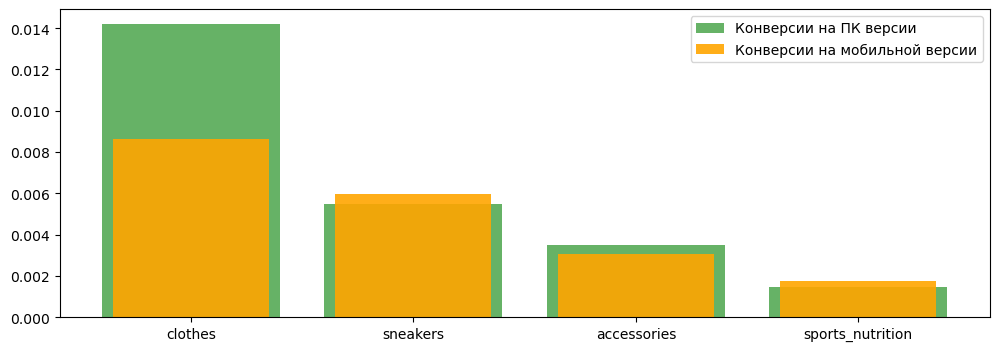

In [416]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.bar(desktop_show_order_conversion.keys(), desktop_show_order_conversion.values(), color='green', alpha=0.6, label="Конверсии на ПК версии")
ax.bar(mobile_show_order_conversion.keys(), mobile_show_order_conversion.values(), color='orange', alpha=0.9, width=0.7, label="Конверсии на мобильной версии")

ax.legend()
plt.show()

Для конверсии из показа в покупку всё не так однозначно... Для ПК версии однозначно лидирует одежда, а также аксессуары. Для мобильной версии - обувь и спортпит. Еще раз напомню, что до этого мы исследовали влияние баннера на прохождение по клиентсокй воронки.
Сейчас же давайте посмотрим на отношение количества товаров, купленных после клика на баннер, к общему количеству купленных товаров в этой категории (то есть насколько покупка данного товара обусловлена рекламой).

In [417]:
desktop_num_order = desktop_df.loc[raw_df['title'] == 'order', 'product'].value_counts()
mobile_num_order = mobile_df.loc[raw_df['title'] == 'order', 'product'].value_counts()
desktop_efficiency = {product: orders/desktop_num_order[product] for product, orders in desktop_num_click_order.items()}
mobile_efficiency = {product: orders/mobile_num_order[product] for product, orders in mobile_num_click_order.items()}

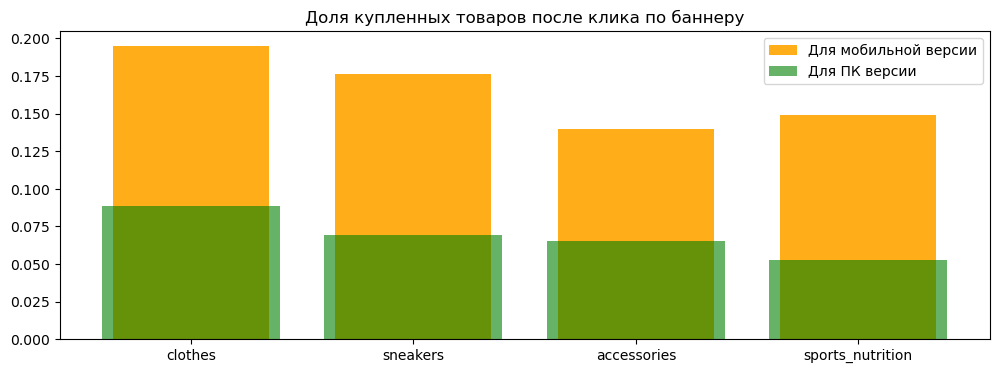

In [418]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.bar(mobile_efficiency.keys(), mobile_efficiency.values(), color='orange', alpha=0.9, width=0.7, label="Для мобильной версии")
ax.bar(desktop_efficiency.keys(), desktop_efficiency.values(), color='green', alpha=0.6, label="Для ПК версии")

ax.legend()
ax.set_title("Доля купленных товаров после клика по баннеру")
plt.show()

Видим, что покупки, мотивированные рекламой, на мобильной версии значительно выше, чем на ПК. Наименьшей эффективностью обладает баннер спортпита (и по воронке, и по итоговой доле, приведенной на последней гистограмме).

Размышляя над эффективностью рекламы, я подумал: а не получается ли так, что на банер кликают только тогда, когда пришли с намерением купить этот товар? В голову к покупателю не заглянешь, зато есть возможность посмотреть, какова доля клиентов, которые увидели баннер с подходящим товаром (который потом был куплен), но при этом на него не кликнули.

In [419]:
#тут должен быть код для доказательства или опровержения вышеупомянутой гипотезы, но с ходу я его написать затрудняюсь, а времени в жизни как-то катастрофически мало:(
'''
жалкие попытки:
desktop_order_groups = desktop_order.groupby('user')
desktop_order_groups.filter(lambda user: ~desktop_order.loc[desktop_order['title'] == 'banner_show', ['product']].isin(desktop_order.loc[desktop_order['title'] == 'banner_click', ['product']]).sum() == 0)
'''

"\nжалкие попытки:\ndesktop_order_groups = desktop_order.groupby('user')\ndesktop_order_groups.filter(lambda user: ~desktop_order.loc[desktop_order['title'] == 'banner_show', ['product']].isin(desktop_order.loc[desktop_order['title'] == 'banner_click', ['product']]).sum() == 0)\n"

В качестве рекламного места, которое может быть продано, рассмотрим место банеров для аксессуаров и спортпита (наименьшие продажи и наименьшая эффективность рекламы). Также можно рассматривать для продажи баннер с рекламой интернет-магазина, но по имеющимся данным лично я не понимаю, как оценить его эффективность. Можно было бы провести А/B тест и понять, как его отсутствие или сразу - появление чужой рекламы повлияет на продажи в целом (не будет ли это, например, отталкивать покупателя, зависит от самого контента, может и наоборот замотивировать (например, реклама качалки:))

Так как на телефонах кликают активнее, то в первую очередь логично разобраться с местами аксессуаров и спортпита на мобильной версии. Возьмем некоторый реально существующий магазин N и найдем в нем средние цены на товары из соответствующих категорий (например, средние по первым 10 с фильтром 'популярные'). Для спортпита пусть это 500р, а для аксессуаров 1200. Можно найти среднее количество покупок за сутки в данных категориях:

In [420]:
orders = desktop_order.loc[desktop_order['title']=='order', 'product'].value_counts()

In [421]:
print(f'Среднее количество покупок за день в категории спортивное питание через баннер: {round(mobile_num_click_order.loc['sports_nutrition']/abs((raw_df['time'].min() - raw_df['time'].max()).days), 0)}')
print(f'Среднее количество покупок за день в категории аксессуары через баннер: {round(mobile_num_click_order.loc['accessories']/abs((raw_df['time'].min() - raw_df['time'].max()).days), 0)}')

Среднее количество покупок за день в категории спортивное питание через баннер: 12.0
Среднее количество покупок за день в категории аксессуары через баннер: 21.0


Если мы все-таки наивно предположим, что, убрав рекламу, мы лишимся этих продаж, то итоговая стоимость рекламы сторонней компании на этих местах за сутки должна быть не менее:

In [422]:
print(f'Для спортпита: {500*12}')
print(f'Для аксессуаров: {1200*21}')

Для спортпита: 6000
Для аксессуаров: 25200


Величина CPC будет зависеть от того, сколько кликов за сутки будут совершать пользователи. Для этого, как мне кажется, нужен эксперимент.

ВЫВОДЫ. 
Запускаем рекламу в первую очередь на мобильных устройствах в категориях спорт-питание и/или аксессуары. Следим за количеством кликов, за влиением на общие продажи. Если на общие продажи не влияет негативно, то устанавливаем цену и оставляем. Далее аналогично можно раскатить на сайт (можно так же последить за продажами и кликами или сразу же пропорционально аудитории пользователей ПК версии установить цену).